In [ ]:
import qiskit
import qiskit.quantum_info
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_aer import AerSimulator
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer.noise import NoiseModel, depolarizing_error
import numpy as np
from qiskit_aer.primitives import Sampler as AerSampler
import matplotlib as plt

In [ ]:
backend = AerSimulator()
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)

In [97]:
def gen_chsh(x, y, num_qubits=2, phase=np.pi/4):

    base_qc = qiskit.QuantumCircuit(num_qubits, 2)

    base_qc.h(0)
    base_qc.cx(0, num_qubits - 1)

    if x == 1:
        base_qc.h(0)

    if y == 0:
        base_qc.ry(-phase, num_qubits - 1)
    elif y == 1:
        base_qc.ry(phase, num_qubits - 1)   

    base_qc.measure(0, 0)
    base_qc.measure(num_qubits-1, 1)
    #measure_all() #([0, 1], [0, 1])

    return base_qc

##### Why $\frac{\pi}{4}?$

The reason behind why $\frac{\pi}{4}$ is the optimal rotation in the y-axis is becuase of what basis Bob is measuring in. To achive Tsirelson's bound ($S = 2\sqrt2$) you start in the entangled bell state and then change the measurment basis based on values of $x$ and $y$. 

The following is based on this proof: https://math.ucsd.edu/sites/math.ucsd.edu/files/XiaoFeng.pdf

Let alice have the angles to meausre in be $\alpha, \alpha'$ and Bob have $\beta, \beta'$ and they share the bell state. Then their coorelation is
$$E(\alpha, \beta) = cos[2(\alpha -\beta)]$$
and the CHSH parameter becomes:
$$S = cos[2(\alpha -\beta)] - cos[2(\alpha' -\beta)] + cos[2(\alpha -\beta')] - cos[2(\alpha' -\beta')]$$

If we let $\alpha = 0, \alpha = \pi/2$ and $\beta = \theta, \beta' = \theta$ and we subsistue into the CHSH paramter we have:
$$S(\theta) = 4cos(2\theta)$$ 
amd to maximize $S(\theta)$ we need to find where the max of $cos(2\theta)$ occurs. We find that $\theta = \pi$ and $S$ can equal $4$, but this isn't physically realizable and the max of $S$ is futhere below that which is why $\theta$ can only go up to $\frac{\pi}{4}$.

In [106]:
import numpy as np

target = np.pi / 4 # want to make sure pi/4 is in the set of phases
start = -np.pi / 2
stop = 3 * np.pi

for N in range(31, 100):
    phases = np.linspace(start, stop, N)
    if np.any(np.isclose(phases, target, atol=1e-6)):
        print(f"Found a match with N = {N}")
        break

Found a match with N = 43


In [107]:
phases = np.linspace(-np.pi/2, 3*np.pi, 43)
print(phases)

[-1.57079633 -1.30899694 -1.04719755 -0.78539816 -0.52359878 -0.26179939
  0.          0.26179939  0.52359878  0.78539816  1.04719755  1.30899694
  1.57079633  1.83259571  2.0943951   2.35619449  2.61799388  2.87979327
  3.14159265  3.40339204  3.66519143  3.92699082  4.1887902   4.45058959
  4.71238898  4.97418837  5.23598776  5.49778714  5.75958653  6.02138592
  6.28318531  6.54498469  6.80678408  7.06858347  7.33038286  7.59218225
  7.85398163  8.11578102  8.37758041  8.6393798   8.90117919  9.16297857
  9.42477796]


In [86]:
circuits = []
input_pairs = []
for x_in in [0, 1]:
    for y_in in [0, 1]:
        input_pairs.append((x_in, y_in))
        circuits.append(gen_chsh(x_in, y_in, 12))

In [76]:
print(circuits)

[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x13af9ba10>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x13af9add0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x13af9b850>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x13af9b930>]


In [60]:
noise_model = NoiseModel()
cx_depolarizing_prob = 0.02
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(cx_depolarizing_prob, 2), ["cx"]
)

### Work in Progress Below

In [92]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.noise import NoiseModel

service = QiskitRuntimeService()
backend = service.backend("ibm_torino")
noise_model = NoiseModel.from_backend(backend)

In [90]:
service.backends()

[<IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_sherbrooke')>,
 <IBMBackend('ibm_torino')>]

In [93]:
from qiskit_aer import AerSimulator
from qiskit import transpile

simulator = AerSimulator(noise_model=noise_model)
transpiled_circuits = [transpile(circ, simulator) for circ in circuits]

results = simulator.run(transpiled_circuits, shots=1024).result()
counts_list = [results.get_counts(i) for i in range(len(transpiled_circuits))]


--- Simulation Results (Counts) ---
Inputs (x=0, y=0):
  Outcomes (ba): {'00': 410, '01': 116, '10': 113, '11': 385}
Inputs (x=0, y=1):
  Outcomes (ba): {'00': 385, '01': 122, '10': 124, '11': 393}
Inputs (x=1, y=0):
  Outcomes (ba): {'00': 384, '01': 117, '10': 122, '11': 401}
Inputs (x=1, y=1):
  Outcomes (ba): {'00': 123, '01': 380, '10': 415, '11': 106}

Plotting results...


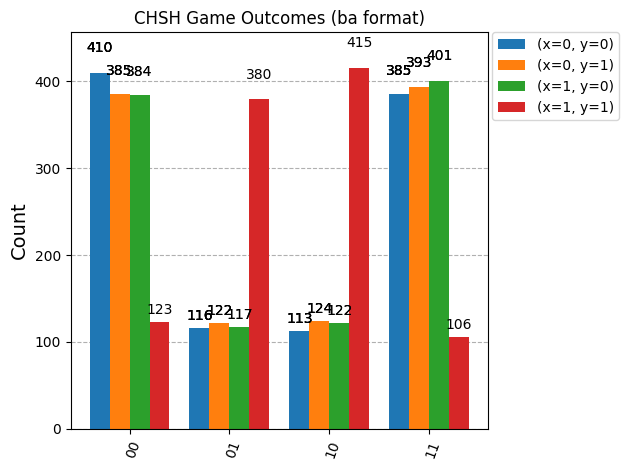

In [94]:
SHOTS=1024

print("\n--- Simulation Results (Counts) ---")
for i, (x, y) in enumerate(input_pairs):
    print(f"Inputs (x={x}, y={y}):")
    sorted_counts = dict(sorted(counts_list[i].items()))
    print(f"  Outcomes (ba): {sorted_counts}")

print("\nPlotting results...")
display(qiskit.visualization.plot_histogram(counts_list,
                       legend=[f'(x={x}, y={y})' for x, y in input_pairs],
                       title='CHSH Game Outcomes (ba format)'))

In [95]:
def get_expectation(counts):
    agree = counts.get('00', 0) + counts.get('11', 0)
    disagree = counts.get('01', 0) + counts.get('10', 0)
    return (agree - disagree) / SHOTS if SHOTS > 0 else 0

expectations = []
for (x, y), counts in zip(input_pairs, counts_list):
    e = get_expectation(counts)
    print(f"E({x},{y}) = {e:.4f}")
    expectations.append(e)

# CHSH = E(0,0) + E(0,1) + E(1,0) - E(1,1)
chsh_value = abs(expectations[0] + expectations[1] + expectations[2] - expectations[3])
print(f"\nCHSH Value: {chsh_value:.4f}")

E(0,0) = 0.5527
E(0,1) = 0.5195
E(1,0) = 0.5332
E(1,1) = -0.5527

CHSH Value: 2.1582


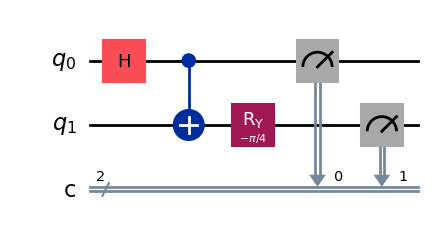

In [ ]:
qc = gen_chsh(0, 0, 2)

qc.draw('mpl')

In [3]:
def cx_chain(n_qubits):
    qc = qiskit.QuantumCircuit(n_qubits)

    half = int(n_qubits / 2)

    for i in range(half - 1):
        qc.cx(i, i + 1)
        qc.cx(i + 1, i)

        qc.cx(n_qubits - (i + 1), n_qubits - (i + 2))
        qc.cx(n_qubits - (i + 2), n_qubits - (i + 1))

    qc.cx(int(n_qubits/2)-1, int(n_qubits/2))

    for i in reversed(range(half - 1)):
        qc.cx(i + 1, i)
        qc.cx(i, i + 1)

        qc.cx(n_qubits - (i + 2), n_qubits - (i + 1))
        qc.cx(n_qubits - (i + 1), n_qubits - (i + 2))

    return qc

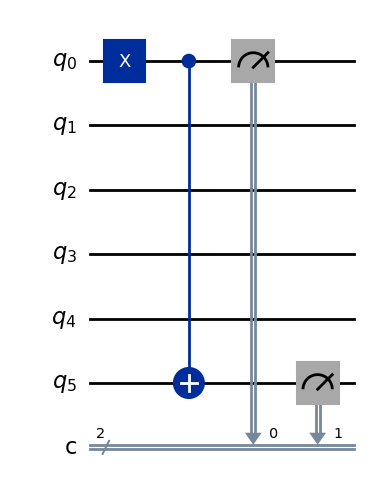

In [ ]:
custom_cnot = cx_chain(6).to_gate(label="CNOT")
qc = qiskit.QuantumCircuit(6, 2)

#qc.h(0)
qc.x(0)
#qc.append(custom_cnot, [0, 1, 2, 3, 4, 5])
qc.cx(0, 5) # used default since has lower depth after transplation
#qc.ry(-np.pi/4, 1)
qc.measure(0, 0)
qc.measure(5, 1)

qc.draw("mpl")

In [ ]:
print("Preparing circuits for the simulator...")
isa_qc_chsh = pm.run(qc)

sampler = Sampler(mode=backend)
counts = sampler.run([isa_qc_chsh], shots = 1000).result()[0].data .c.get_counts()


Preparing circuits for the simulator...


In [32]:
service = qiskit_ibm_runtime.QiskitRuntimeService()

In [33]:
print("The circuit depth is:", qc.depth())
qc_transpiled = qiskit.transpile(qc, service.backend('ibm_brisbane') , optimization_level=3)
print("The TRANSPILED circuit depth is:", qc_transpiled.depth())

The circuit depth is: 3
The TRANSPILED circuit depth is: 8
